# Chapter 3. Unsupervised Learning methods.
# Part 2. Data Preprocessing: PCA, NMF, t-SNE

PCA - principal component analysis

NMF - (non-negative matrix factorization) feature extraction

t-SNE - (t-distributed stochastic neighbor embedding) visualization with scatter plots

## - PCA

PCA principle is about dataset rotation so samples wouldn't correlate

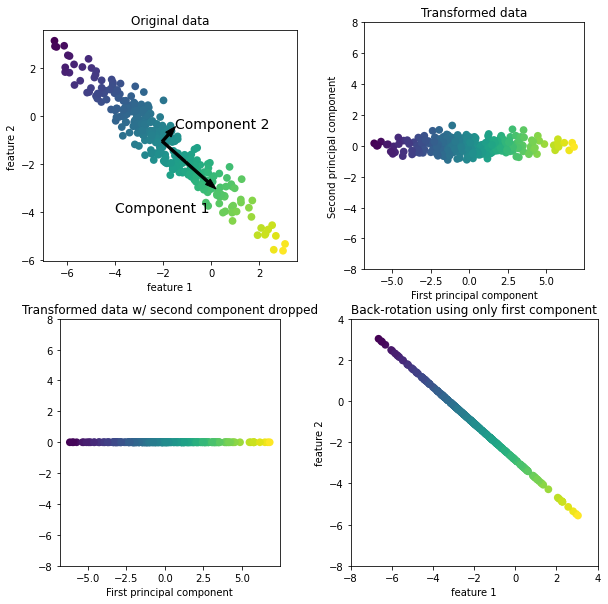

In [8]:
import mglearn
mglearn.plots.plot_pca_illustration()

^ Component is an axis that includes the most of information in dataset (axis of highest data dispersion) picked up iteratively

## PCA for data visualiztion

To get better clue of dataset without PCA it's useful to look at class comparison by a feature:

Text(0, 0.5, 'frequency')

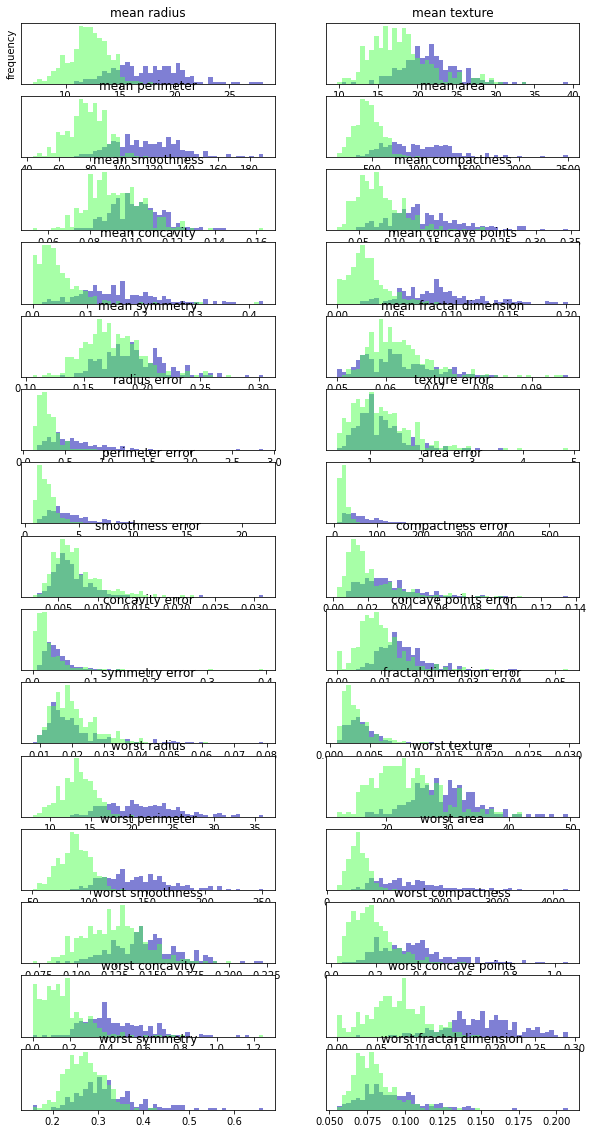

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15,2, figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=0.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel('feature value')
ax[0].set_ylabel('frequency')

^ 'worst cancave points' is pretty useful and 'smoothness error' is not. But this diagram doesn't account for the dependensies between features.

To get better clue of dataset with feature dependensies and correlations it's useful to find principal components via PCA (to prescaled data):

Source dataset shape: (569, 30)
New dataset shape: (569, 2)
Principal components data shape: (2, 30)


Text(0, 0.5, 'Second principal component')

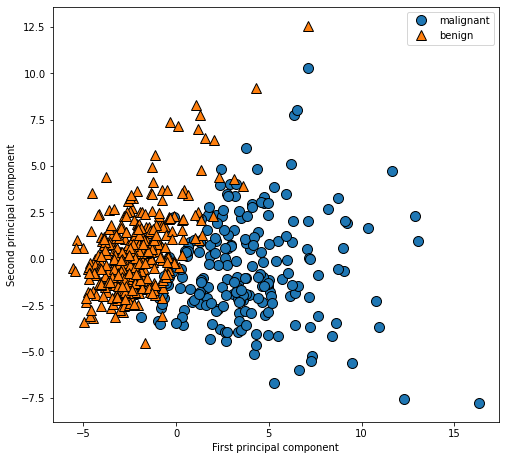

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#-----prescaling data and PCA implementation
#--initialization, building and applying scaler
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

#--initialization, building and applying PCA.
#dimensionality reduction is made by giving an argument to...
#...a PCA object as a count of needed components
pca = PCA(n_components=2)
#'.fit' finds principal components
pca.fit(X_scaled)
#'.transform' rotates and moves data
X_pca = pca.transform(X_scaled)

#--datasets comparison
print('Source dataset shape: {}'.format(str(X_scaled.shape)))
print('New dataset shape: {}'.format(str(X_pca.shape)))

#-----visualizing PCA dataset
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

Principal components are stored in 'components_' and columns are the source features:

Principal components data shape: (2, 30)
Principal components:
 [[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Principal components')

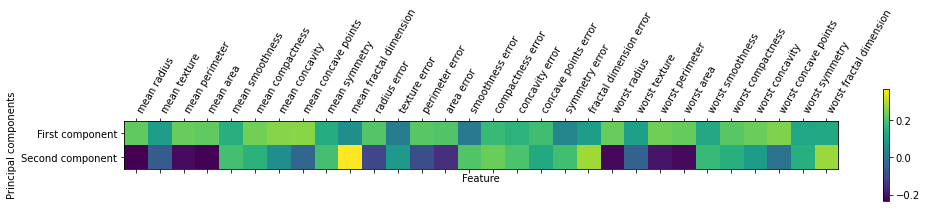

In [28]:
print('Principal components data shape: {}'.format(pca.components_.shape))
print('Principal components:\n {}'.format(pca.components_))

#PCA components visualization via heatmap
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

^ color intensivity tells about correlation strength between all the rest features for component